# DESeq Workshop 1 -  Standard Analyses for RNA-seq Data (unsupervised)


# Abstract

This workshop introduces RNA-seq analysis using R, including the (Ranged)SummarizedExperiment data class, exploratory data analysis and QC, data transformations, and the use of distances to visualize transcriptome shifts.

This workshop uses quotes and materials from [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://www.bioconductor.org/help/workflows/rnaseqGene/) by Love, Anders, Kim, and Huber.

This notebook is forked from [two notebooks originally created by Levi Waldron](https://github.com/compbiocore/bioconductor-workshop-2), with modifications to the text and code performed by Andrew Leith.  The The remaining material will be adapted into a second workshop on differential expression analysis with DESeq2 at a later date.

# Outline

1. Introduction to RNA-seq Data
    * What is RNAseq?
    * Quantifying expression
    * Differential expression
2. Initial Data Exploration
    * SummarizedExperiment 
    * Creating a SummarizedExperiment object from scratch
3. Filtering
4. Data Transformations  
    * log2  
    * rlog  
    * vst  
    * Transformation Visualization  
        * Boxplots  
        * Scatterplots  
5. Sample Heteogenity  
    * Heatmaps  
    * Component plots  
        * PCA plots  
        * MDS plots  

#  Introduction to RNAseq

## What is RNAseq?

The central dogma of biology refers to the concept that in general, information flows from DNA to RNA to proteins, which are the molecules that encode for various enzymes etc., that help a living organism maintain homeostasis and self-regulate. For this workshop, we are going to talk about analyzing transcriptome data, where genes are regulated at the level of DNA being transcribed into RNA.

The general experimental process involves extracting RNA from your different experimental conditions, performing the library preparation steps (e.g., cDNA synthesis, fragmentation, and adding adapters). These libraries are sequenced on an Illumina FlowCell. The output from this process is these raw reads, which you can then align to the appropriate reference genome or transcriptome, where more reads will align to more highly expressed genes. This data can be processed to get back a counts matrix which will let you look at differential expression and perform other downstream analyses.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Journal.pcbi.1004393.g002.png/2560px-Journal.pcbi.1004393.g002.png">

### Some more resources about sequencing technologies:
+ https://www.illumina.com/content/dam/illumina-marketing/documents/products/illumina_sequencing_introduction.pdf      
+ Rory Stark, Marta Grezlak, and James Hadfield. NA sequencing: the teenage years Nature Reviews Genetics *Nature Reviews Genetics* **20,** 631-656 (2019)      

## Computational workflow overview

The computational analysis of an RNA-seq experiment begins from the raw FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads are **aligned** to a reference genome and the alignment files (.SAM or .BAM file) are turned into a counts matrix by programs such as HTSeq or featureCounts. Some newer and very fast alignment-free approaches can also estimate counts per transcript **without alignment**. Instead of directly aligning RNA-seq reads to a reference genome, they perform "pseudo-alignment" by assigning reads to transcripts that contain compatible k-mers and generate a table of read counts without the need for a counting step.

<img src="images/rnaseq_workflow.png">

There are many different programs for running alignment-based quantification. Each alignment program will make different assumptions about the data and will show some variation in performance. For example, not all aligners are 'splice-aware', which means that they will recognize intron-sized gaps that are spliced from transcripts. Some popular alignment-based tools include [STAR](https://github.com/alexdobin/STAR), [HISAT2](https://daehwankimlab.github.io/hisat2/), [GSNAP/GMAP](http://research-pub.gene.com/gmap/), among many others. Counts can be generated from SAM/BAM alignments using programs such as [featureCounts](http://bioinf.wehi.edu.au/featureCounts/) or [HTSeq](https://htseq.readthedocs.io/en/master/). 

<div class="alert alert-block alert-info"><b>Note:</b> The information you get back from directly aligning RNAseq reads to a genome will be dependent on the quality of the annotations, which are not always great (especially for non-model organisms). </div>

Alignment-free tools have gained popularity for their fast performance and low memory requirements while maintaining good accuracy.  The most popular of these tools are [Salmon](https://combine-lab.github.io) and [Kallisto](https://pachterlab.github.io/kallisto/). 

The differential expression analyses introduced here assume you are analyzing a raw counts table, where the rows are the genes or transcripts and the columns are your samples. It is always a good idea to read the documentation for any of these programs to make sure you understand what file formats should be used. The two most popular programs for  differential expression analyses are probably [DESeq2](http://bioconductor.org/packages/DESeq2) and [edgeR](http://bioconductor.org/packages/). Each program makes different assumptions and has different approaches to normalizing the data, and they will likely give you slightly different numbers of differentially expressed genes if you run both programs. 

The counts matrices can also be transformed so that they are compatible with common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), which work best for data that have the same variance at different mean values, i.e. the mean and variance are independent.

<div class="alert alert-block alert-info"><b>Note:</b> The rest of this workshop assumes you are starting with the output of some sequence analysis pipeline (i.e. counts). </div> 


# Initial data exploration

## Standard data types

### Counts matrices
The counts matrix is a simple, standard way to represent RNAseq experiments. The rows correspond to genes, the columns correspond to each sample, and the data are the counts.

<img src="images/counts_matrix.png" width="300">
 
### SummarizedExperiment

The SummarizedExperiment is a data class for representing RNA-seq data. It builds on a simple counts matrix to include information about samples. It can also optionally include information about exons and genes, the experimental design, and additional metadata.

**The component parts of a *SummarizedExperiment* object `se` are:** 

* `assay(se)` or `assays(se)$counts` contains the matrix of counts
* `colData(se)` may contain data about the columns, e.g. patients or biological units
* `rowData(se)` may contain data about the rows, e.g. genes or transcript
* `rowRanges(se)` may contain genomic ranges for the genes/transcripts
* `metadata(se)` may contain information about the experiment

<img src="images/summarizedexperiment.png">

Load the `airway` and `SummarizedExperiment` packages.

In [1]:
suppressMessages(library(airway))
suppressMessages(library(SummarizedExperiment))

For the purposes of this tutorial, we will be using the `airway` data. This data is in the `airway` package, stored as a `RangedSummarizedExperiment` object -- a type of `SummarizedExperiment`. Four human airway smooth muscle cell lines were left untreated or treatreated with dexamethasone for 18 hours (Himes et al. 2014).

In [2]:
data(airway)
airway

class: RangedSummarizedExperiment 
dim: 64102 8 
metadata(1): ''
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

Use the `assays` function to see the names of the assays stored in the object.

In [3]:
assays(airway)

List of length 1
names(1): counts

We can use the `$` accessor to view the `counts` assay. We will combine that with `head` and `assay` functions to access the first view rows of the counts matrix. The rows are genes, the columns are the samples, and the data are the counts:

In [4]:
head(assays(airway)$counts)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0


***

Use the `colData` function to see more information about each sample:

In [5]:
head(colData(airway))

DataFrame with 6 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862  N61311     untrt    untrt SRR1039508       126
SRR1039509 GSM1275863  N61311     trt      untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611    trt      untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611    trt      untrt SRR1039517       126
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN02422670
SRR1039516  SRX384353 SRS508575 SAMN02422682
SRR1039517  SRX384354 SRS508576 SAMN02422673

You can use the `$` accessor to access the individual columns (like you would with a data frame).

In [6]:
levels(colData(airway)$dex)

[1] "trt"   "untrt"

## Creating a SummarizedExperiment object from scratch

You can create `SummarizedExperiment` objects using the `SummarizedExperiment` function. The `assay` and `colData` arguments are required. 

In [ ]:
airway_counts <- assay(airway)
airway_samples <- colData(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples)
new_se

Use `?` to get more information about the function:

In [ ]:
?SummarizedExperiment

<div class="alert alert-block alert-success"><b>Exercise:</b> How would you create a new SummarizedExperiment object that contains information about the genes in the airway data (e.g., the rows)? What about additional metadata? </div>

In [ ]:
airway_ranges <- rowRanges(airway)
airway_metadata <- metadata(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples, 
                               rowRanges = airway_ranges,
                               metadata = airway_metadata)
new_se

# Exploring the airway dataset

Exploratory data analysis of RNAseq data is an important step for assessing data quality. You can look at the expression of genes of interest or relationships/similarities among sample groupings. Filtering and exploring your data is an iterative process; as you explore and visualize your data you can tweak your filtering parameters to see how the filtering impacts the results.

## Creating a `DESeqDataSet`

Once we have our fully annotated *SummarizedExperiment* object,
we can construct a *DESeqDataSet* object from it that will then form
the starting point of the exploratory analysis. Here, `~ cell + dex` means that we are concerned with two covariates, the cell line (`cell`) and whether or not the samples were treated with dexamethasone (`dex`).

In [7]:
suppressPackageStartupMessages(library(DESeq2))

In [8]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)

## Filtering genes not satisfying a minimum expression threshold

Our count matrix might contain rows with only zeroes or genes that are very lowly expressed in every condition tested. These genes are not likely to be informative, so to reduce the size of the object we can remove these rows.
Here, we remove rows of the *DESeqDataSet* that
have no counts, or only a single count across **all** samples. First, we can use `nrow` to see how many genes are in the dataset before we filter:


In [9]:
nrow(dds)

[1] 64102

Let's re-assign `dds` to `dds.original` before we do any filtering.

In [10]:
dds.original <- dds

Look at the first few lines using `head`

In [11]:
head(counts(dds.original))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0


Let's filter the expression matrix so we are including genes that have at least one fragment mapped in at least 1 sample (or `rowSums` greater than 1).

In [12]:
dds <- dds[ rowSums(counts(dds)) > 1, ]

Let's look at the first few rows:

In [13]:
head(counts(dds))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0
ENSG00000000971,3251,3679,6177,4252,6721,11027,5176,7995


Notice that the gene that had zero counts in every sample (`ENSG00000000005`) is gone, but `ENSG00000000938` remains because it has a rowSum greater than 1. How many genes do we have left after filtering?

In [14]:
nrow(dds)

[1] 29391

Only 46% of the genes remain after performing this filtering step. A more stringent method of filtering, such as removing all genes that have any 0 count entries at all, would yield an even smaller percentage of genes. Let's look at the count densities from before and after filtering:

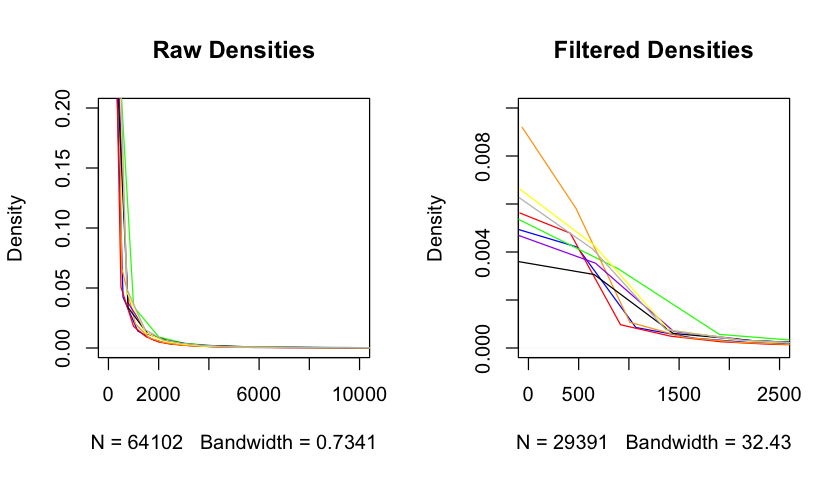

In [15]:
options(repr.plot.height=4, repr.plot.width=7)
par(mfrow=c(1,2))

plot(density(as.data.frame(counts(dds.original))$SRR1039508), xlim = c(0, 10000), ylim = c(0, .2), main = "Raw Densities", col = "Blue")
lines(density(as.data.frame(counts(dds.original))$SRR1039509), col = "Red")
lines(density(as.data.frame(counts(dds.original))$SRR1039512), col = "Green")
lines(density(as.data.frame(counts(dds.original))$SRR1039513), col = "Orange")
lines(density(as.data.frame(counts(dds.original))$SRR1039516), col = "Purple")
lines(density(as.data.frame(counts(dds.original))$SRR1039517), col = "Black")
lines(density(as.data.frame(counts(dds.original))$SRR1039520), col = "Yellow")
lines(density(as.data.frame(counts(dds.original))$SRR1039521), col = "Gray")

plot(density(as.data.frame(counts(dds))$SRR1039508), xlim = c(0, 2500), ylim = c(0, .01), main = "Filtered Densities", col = "Blue")
lines(density(as.data.frame(counts(dds))$SRR1039509), col = "Red")
lines(density(as.data.frame(counts(dds))$SRR1039512), col = "Green")
lines(density(as.data.frame(counts(dds))$SRR1039513), col = "Orange")
lines(density(as.data.frame(counts(dds))$SRR1039516), col = "Purple")
lines(density(as.data.frame(counts(dds))$SRR1039517), col = "Black")
lines(density(as.data.frame(counts(dds))$SRR1039520), col = "Yellow")
lines(density(as.data.frame(counts(dds))$SRR1039521), col = "Gray")

As we can see, **the count densities before and after filtration are radically different**, even with the raw densities portrayed over larger axis ranges. Before we ran the filtering, there were over 30,000 zero-count genes that were shifting the density so that almost all of the area under the curve is near 0.

These genes do not contribute meaningful information to our analysis (and can even bias some of our analytical techniques) so we remove them.

**Note**: For differential expression analysis later, filtering is 
allowable but not necessary if using [Independent Hypothesis Weighting](http://www.bioconductor.org/packages/IHW),
as is the default behavior of `DESeq2`. Independent hypothesis weighting (IHW) is a multiple testing procedure that increases power compared to the method of Benjamini and Hochberg by assigning data-driven weights to each hypothesis.

## Data Transformation

Why transform the data? Many common statistical methods for *exploratory* analysis of
multidimensional data, for example clustering and *principal
components analysis* (PCA), **work best for data that generally has the
same variance across different values of the mean**. When
the expected amount of variance is approximately the same across
different mean values, the data is said to be *homoskedastic*. For
RNA-seq count data, however, the expected variance grows with the mean. The problem with this mean-variance relationship is that **if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with the *highest* counts because they show the largest absolute differences between samples**. Simply put, the genes with the highest counts (i.e., those that are more highly expressed) will dominate the analysis simply due to them having more variability. A simple and often used strategy to address this problem is to take the logarithm of the normalized
count values plus a pseudocount of 1 (this pseudocount of 1 accounts for 0-count observations, as the log of 0 is undefined and the log of 1 is always 0, irrespective of base); however, this approach can also introduce problems; depending on the choice of pseudocount, the genes with the very *lowest* counts
will now contribute a great deal of noise to the resulting plot, because
taking the logarithm of small counts actually inflates their variance. As a solution, DESeq2 offers two additional transformations for count data that stabilize the variance across the mean: the regularized-logarithm transformation or rlog (Love, Huber, Anders, Genome Biology 2014); and the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber, Genome Biology 2010), implemented in the `vst` function.

First, lets quickly compare some scatterplots of counts transformed using these three different methods:

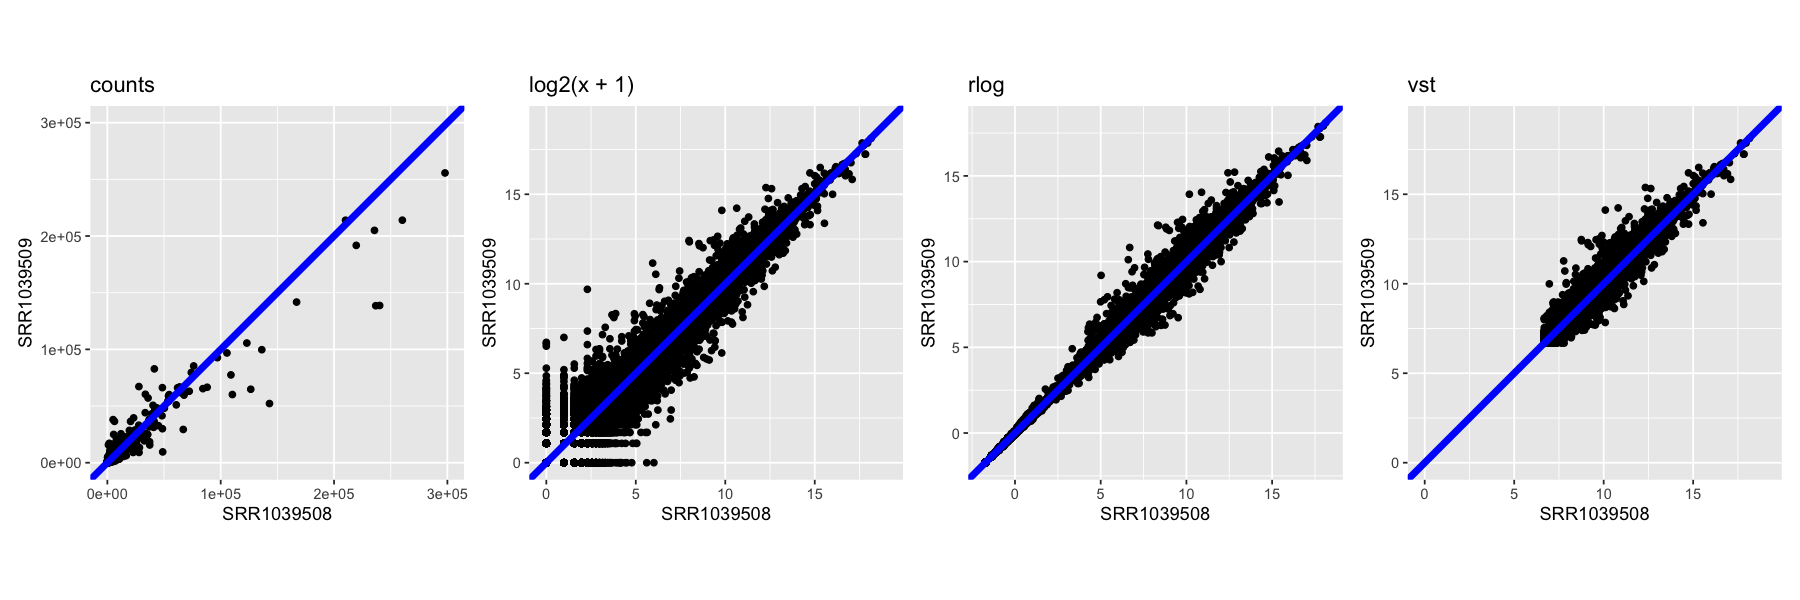

In [178]:
suppressMessages(library(vsn))
rld <- DESeq2::rlog(dds, blind = FALSE) #rlog
vsd <- vst(dds, blind = FALSE) #vst
ddsESF <- estimateSizeFactors(dds) #estimate size factors first
logt <- data.frame(log2(counts(ddsESF, normalized=TRUE)[, 1:2] + 1)) #standard log2

p1 <- ggplot(data.frame(assay(dds)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,300000)+
ylim(0,300000) +
ggtitle('counts')

p2 <- ggplot(logt, aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,19)+
ylim(0,19) +
ggtitle('log2')

p3 <- ggplot(data.frame(assay(rld)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
ggtitle('rlog')

p4 <- ggplot(data.frame(assay(vsd)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,19)+
ylim(0,19) +
ggtitle('vst')

options(repr.plot.width=15, repr.plot.height=5)

p1 | p2 | p3 | p4

Here are some scatter plots showing the raw counts and the log2 (left), rlog (middle), and VST (right) transformed counts. The x and y axes are expression values in two samples from the `airway` data. Each black dot is a gene and its position on the plot indicates its expression levels in two of the `airway` data samples. The blue line is indicating the 1:1 line -- points closer to this line have similar expression values in sample x and in sample y. Genes in the bottom left corner are lowly expressed and genes in the upper right corner are highly expressed.    

We can see how genes with low counts (bottom left-hand corner) are highly variable on the ordinary logarithmic scale (`log2`), while the `rlog` transform and `vst` compress differences for the low count genes. Since these low-count values are likely artifacts introduced by sequencing error or random chance, their exclusion helps to prevent false positives.  

Plotting the standard deviation of each row (gene) against the mean is also helpful for understanding how data transformations impact the mean:variance relationship:

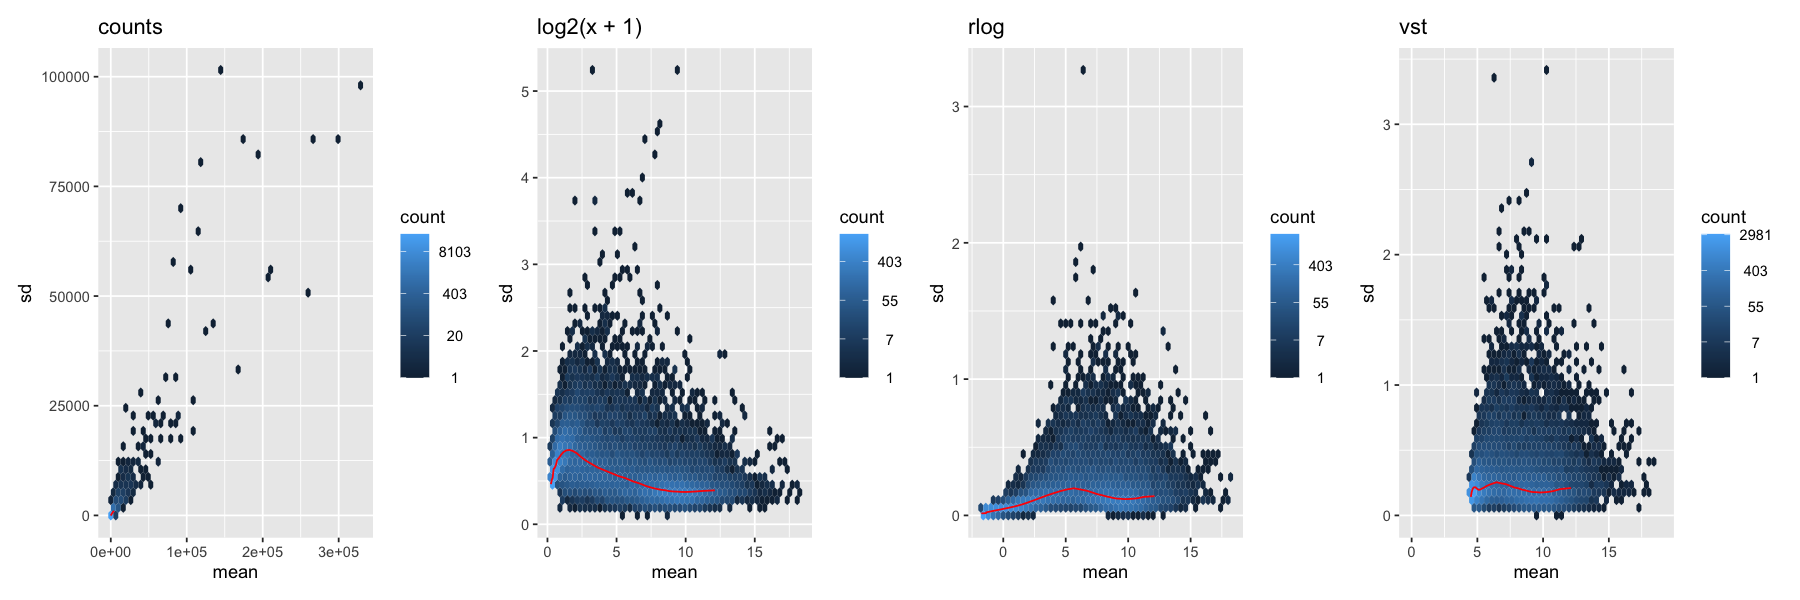

In [189]:
p5 <- meanSdPlot(counts(dds), ranks = FALSE, plot = FALSE)
#p6 <- meanSdPlot((log2(counts(dds) + 1)), ranks = FALSE, plot = FALSE)
P6 <- meanSdPlot((log2(counts(ddsESF) + 1)), ranks = FALSE, plot = FALSE)
p7 <- meanSdPlot(rlog(counts(dds)), ranks = FALSE, plot = FALSE)
p8 <- meanSdPlot(vst(counts(dds), blind = FALSE), ranks = FALSE, plot = FALSE)

p5$gg + ggtitle('counts')| p6$gg + ggtitle('log2') | p7$gg + ggtitle('rlog') | p8$gg + ggtitle('vst')  + scale_x_continuous(limits = c(0, 19))  

**Note the differences in the axis scales**

First, we can look at the the untransformed data on the far left. Note the extreme outliers in the upper right of the plot, each colored dark blue to show that very few genes fall within each point - these observations would cause a great deal of bias in the result if uncorrected.

We see that transforming our data using the logarithm with a small pseudocount transformation (i.e., the standard log2 transformation) amplifies differences when the
values are close to 0. As a result, the low count genes with low signal-to-noise
ratio will now overly contribute to sample-sample distances and PCA
plots.  

For genes with high counts, the rlog and VST transformations will give results similar
to that of the ordinary log2 transformation of normalized counts.  **For genes
with lower counts, however, the values are shrunken towards the genes'
averages across all samples**. The rlog-transformed or VST data then
becomes approximately homoskedastic, and can be used directly for
computing distances between samples, making PCA plots, or as input to
downstream methods which perform best with homoskedastic data.

**Which transformation to choose?** The rlog tends to work well on
small datasets (n < 30), sometimes outperforming the VST when there is
a large range of sequencing depth across samples (an order of
magnitude difference). However, the VST is much faster to compute and is less
sensitive to high count outliers than the rlog. We therefore recommend
the VST for large datasets (hundreds of samples). You can perform both
transformations and compare the `meanSdPlot` or PCA plots generated,
as described below.

turn this into warning box:
**Using transformed or normalized counts is only for visualizing and exploring data -- statistical analysis packages like DESeq2 and edgeR should be used with raw counts matrices**

<div class="alert alert-block alert-warning"><b>Exercise:</b> How would you create a new SummarizedExperiment object that contains information about the genes in the airway data (e.g., the rows)? What about additional metadata? </div>

In the above function calls, we specified `blind = FALSE`, which means
that differences between cell lines and treatment (the variables in
the design) will not contribute to the expected variance-mean trend of
the experiment. The experimental design is not used directly in the
transformation, only in estimating the global amount of variability in
the counts.  For a fully *unsupervised* transformation, one can set
`blind = TRUE` (which is the default).

To show the effect of the transformation, in the figure below
we plot the first sample
against the second, first simply using the *log2* function (after adding
1, to avoid taking the log of zero, which as previously mentioned is undefined and would cause an error), and then using the rlog- and VST-transformed
values. **For the *log2* approach, we need to first estimate *size factors* to
account for sequencing depth**, and then specify `normalized=TRUE`.
Sequencing depth correction is done automatically for the *rlog*
and the *vst*.


## Exploring data at the sample level

### Boxplots

Boxplots of the count distributions in each sample are a good way to understand the effects these transformations have at the level of individual subjects.

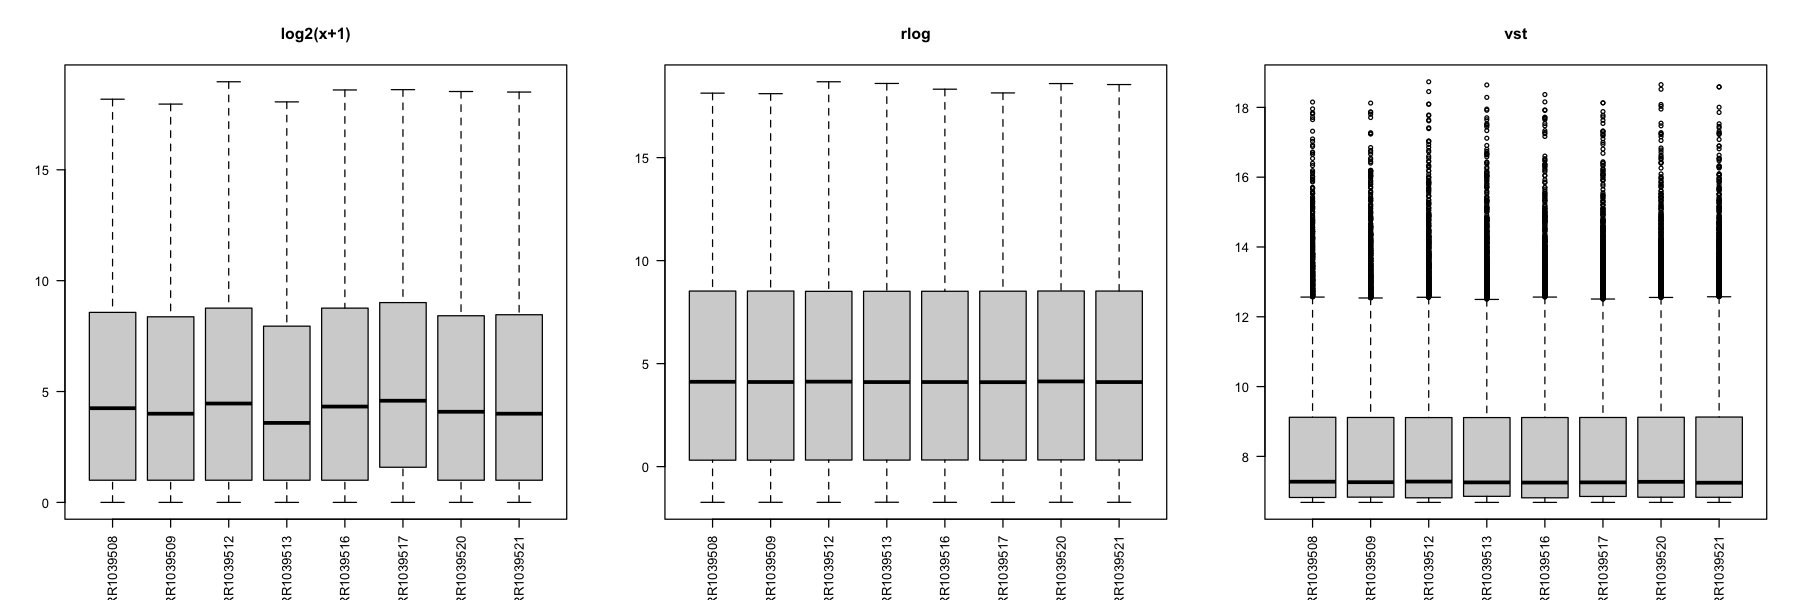

In [190]:
par(mfrow=c(1,3))
boxplot(log2(assay(ddsESF)+1), las=2, main="log2(x+1)")
boxplot(assay(rld), las=2, main="rlog")
boxplot(assay(vsd), las=2, main="vst")

In R's boxplots, points classified as outliers are shown on the plots as circles. Neither the standard log2 or the rlog transformations include any outliers, while the vst transformations do have outliers at the upper end of the distributions.  These points are classified as outliers because the vst method compresses lower end points more substantially (which can be seen on the scatter plots above). The actual magnitude of these points does not significantly exceed the magnitude seen with the other transformations.

### Correlation plots

    We can also use correlation plots (using the `ggpairs` function) to look at trends across samples:

In [210]:
suppressMessages(library(GGally))

In [223]:
?ggpairs

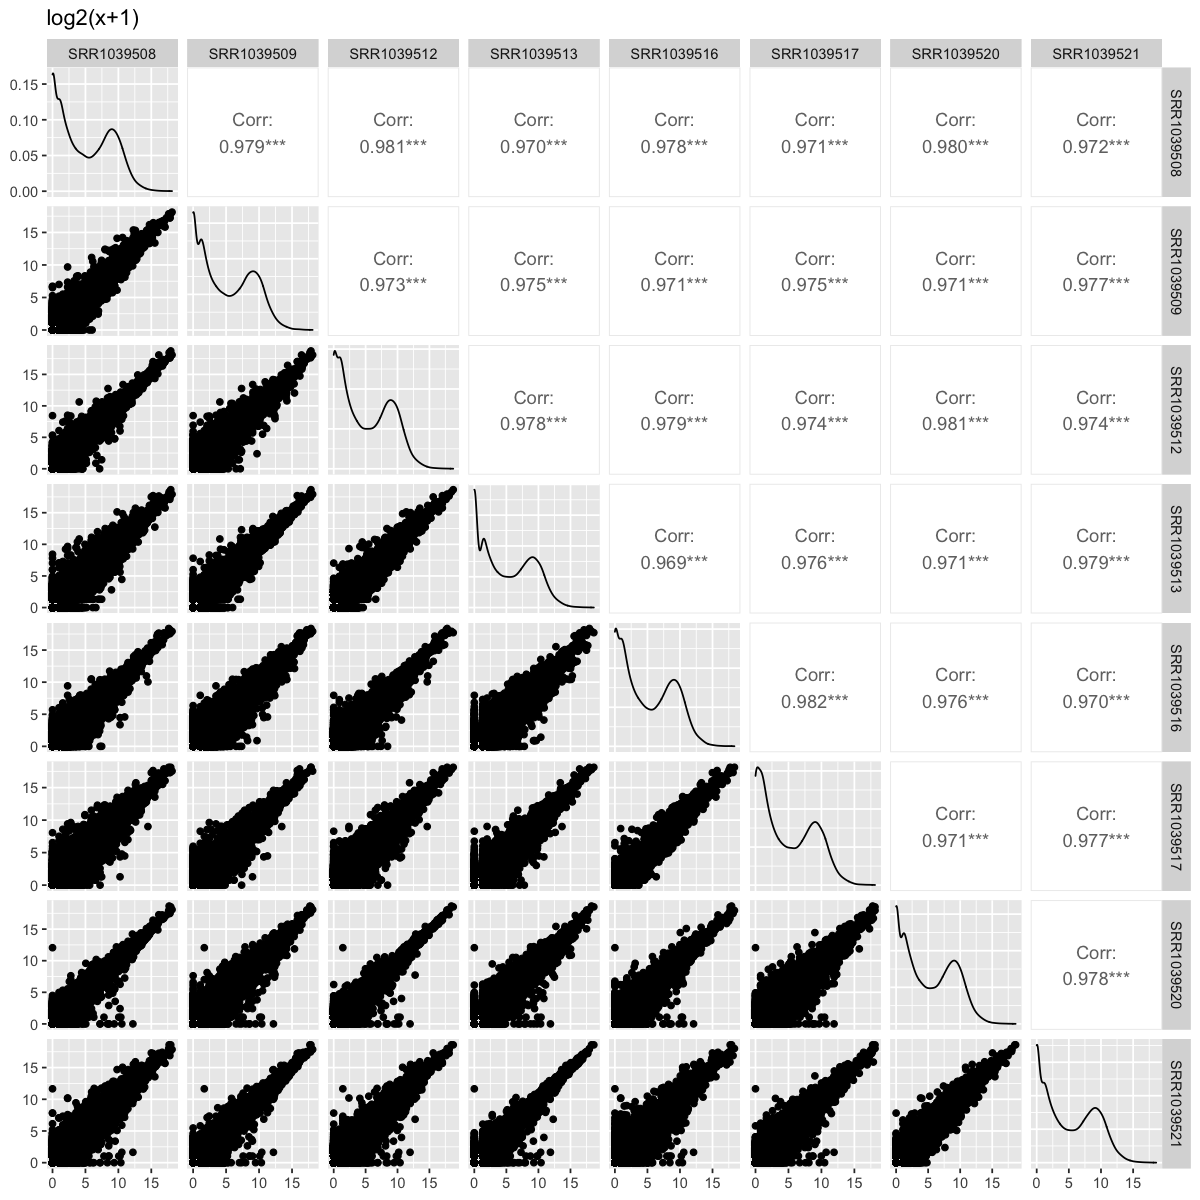

In [222]:
options(repr.plot.width=10, repr.plot.height=10)
ggpairs(as.data.frame(log2(counts(ddsESF, normalized=TRUE) + 1)), title = 'log2(x+1)')


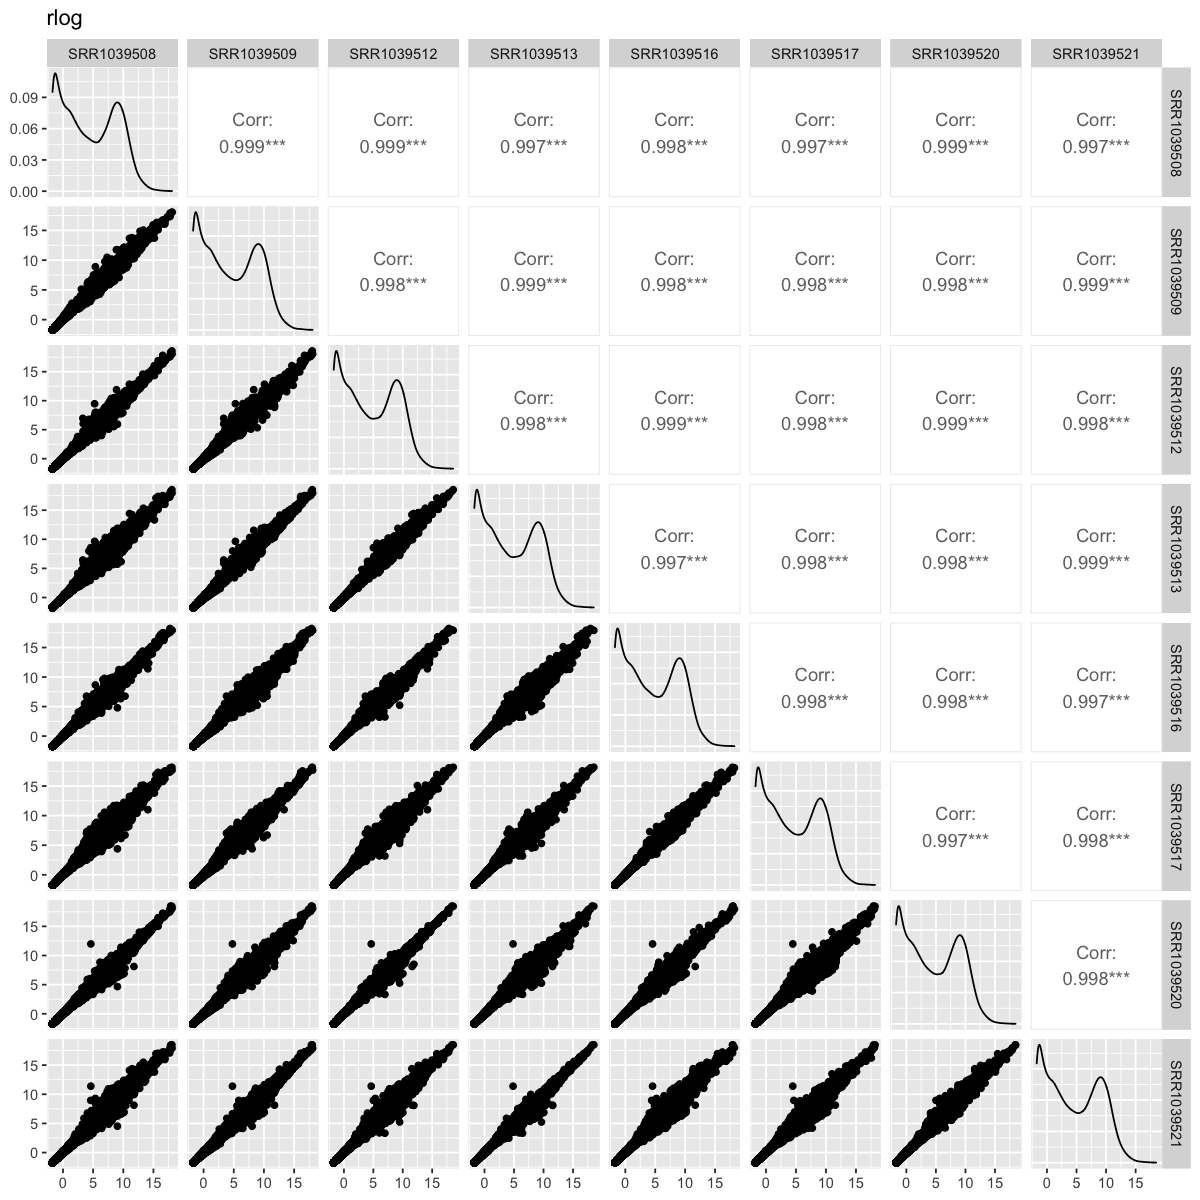

In [214]:
ggpairs(as.data.frame(rlog(counts(dds))), title = 'rlog')

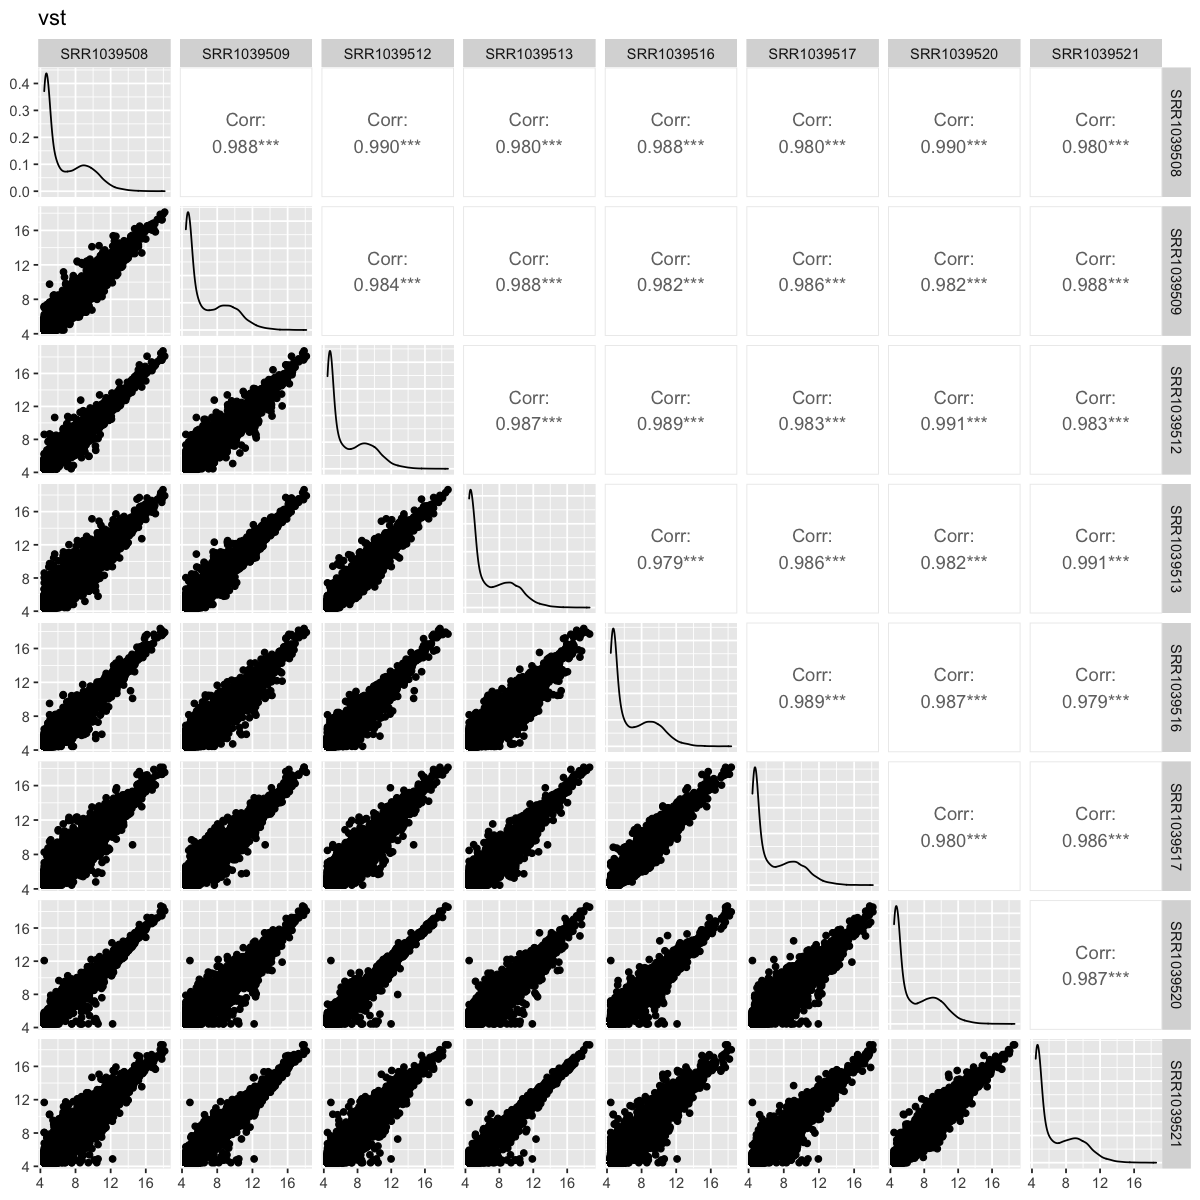

In [215]:
ggpairs(as.data.frame(vst(counts(dds))), title = 'vst')

Starting in the lower left corner of the `ggpairs` plot, we see several scatter plots that compare each of the samples. The scatter plots are just like the 1:1 plots shown earlier in this workshop, where each point is a gene and points that are closer to the 1:1 line show similar expression levels in the two samples compared. This lets us see if there are sample-specific differences and how many genes (points) are driving those differences. Distribution plots are shown on the diagonal -- we can see how each of these transformations influences the distribution of the counts -- note the axis ranges on the `vst` plots, which do not start at 0. The upper right corner shows the Pearson correlations.

### Importing biomaRt data

We can also use biomaRt annotations to look for genes of interest in our data. We can use a list of 'housekeeping genes' which are typically considered to be stably expressed and shouldn't show large variations across different samples. We have selected a list of genes based on two publications that queried public cancer genome data to find housekeeping genes for use with RNA-seq from cancer cell lines (https://doi.org/10.1186/s12859-019-2809-2, https://doi.org/10.3389/fgene.2019.00097).


HNRNPL, PCBP1,ER1, RPN1, PUM1, IPO8
For example, lets look at expression of GAPDH gene (Glyceraldehyde 3-phosphate dehydrogenase) in the airway data. -- put the list of marker genes for CK in there and include the references, then that can be the exercise -- we could also add some exercises re: transforming and plotting -- give them one example and have them do the other 3 boxplots or whatever).


First, let's load biomaRt and make a vector of the gene symbols from the published data:

In [224]:
library(biomaRt)
housekeeping <- c('HNRNPL', 'PCBP1','ER1', 'RPN1', 'PUM1', 'IPO8')

Then we can see what our marts are available:

In [246]:
listMarts()

Ensembl site unresponsive, trying uswest mirror



biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 102
ENSEMBL_MART_MOUSE,Mouse strains 102
ENSEMBL_MART_SNP,Ensembl Variation 102
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 102


Let's use the first one listed.

In [240]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', mirror = 'uswest')

Then we can see which datasets are available for human:

In [242]:
searchDatasets(mart = ensembl, pattern = 'hsapiens')

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
80,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


Now we can put it all together...

In [245]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', mirror = 'uswest', dataset='hsapiens_gene_ensembl')
#Ensembl site unresponsive, trying uswest mirror
#ensembl <- useMart(biomart = 'ENSEMBL_MART_ENSEMBL', dataset='hsapiens_gene_ensembl', mirror = 'uswest')
#hs_mart <- useMart(ensembl, ,dataset="hsapiens_gene_ensembl")

#ensembl_bm <- getBM(attributes = c('ensembl_gene_id', 'entrezgene_id', 'hgnc_symbol'),
#      filters = 'hgnc_symbol',
#      values = 'GAPDH', 
#      mart = ensembl_mart)

In [ ]:
airway_vsd <- vst(dds, blind=FALSE)
airway_rld <- rlog(dds, blind=FALSE)



# Sample distances

## The importance of distances


Now we are getting into more of the data exploring. This section should start w box & density plots.
Then move to gene bar plots for specific genes of interest (for example, if you knocked out a gene or whatever).
Could talk about a few house-keeping genes (but they might not always play nicely in RNAseq data -- just look anyway and get a handle on whats happening)

Might want to move the distances thing as like an 'alert' -- we can use dim reduc method to look at distances.


High-dimensional data are complex and impossible to visualize in raw form. They represent
thousands of dimensions, but we can only visualize 2-3.

start w the heatmap, and then get into the details about how its calculated

Next part would be the PCA stuff (Jordan will probably jump in here).

All clustering and classification of samples and/or genes involves
combining or identifying objects that are close or similar. Distances 
or similarities are mathematical representations of what we mean by 
close or similar. The choice of distance is important and varies for different subject areas and types of data.

See: http://master.bioconductor.org/help/course-materials/2002/Summer02Course/Distance/distance.pdf

## Distances for exploratory RNA-seq data analysis

A useful first step in an RNA-seq analysis is often to assess overall
similarity between samples: Which samples are similar to each other,
which are different? Does this fit to the expectation from the
experiment's design? 

To assess similarity, we calculate the "Euclidean distance" between samples using the R function *dist*; the Euclidean distance is simply the higher-dimensional analogue of the human-measurable distance between points in 2 or 3 dimensions.  To ensure we have a roughly equal contribution from
all genes, we calculate it from the **rlog-transformed data**. It is important to note that we need to
transpose the matrix of values using the `t` function, because the `dist` function
expects the different samples to be **rows** of its argument, and
different dimensions (here, genes) to be **columns**.

unrelated to this workshop: look into pcaexplorer package in R.

In [ ]:
sampleDists <- dist(t(assay(rld)))
sampleDists

We visualize the distances in a heatmap in a figure below, using the function
`pheatmap` from the [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html) package.

In [ ]:
library(pheatmap)
library(RColorBrewer)

In order to plot the sample distance matrix with the rows/columns
arranged by the distances in our distance matrix,
we manually provide `sampleDists` to the `clustering_distance`
argument of the `pheatmap` function.
Otherwise the `pheatmap` function would assume that the matrix contains
the data values themselves, and would calculate distances between the
rows/columns of the distance matrix, which is not desired.
We also manually specify a blue color palette using the
`colorRampPalette` function from the [RColorBrewer](https://cran.r-project.org/web/packages/RColorBrewer/index.html) package (this coloring step is optional and is determined by user preference).

In [ ]:
options(repr.plot.height=3, repr.plot.width=5)
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to
contain treatment type and patient number instead of sample ID, so
that we have all this information in view when looking at the heatmap.

Another option for calculating sample distances is to use the
Poisson Distance, implemented in the
[PoiClaClu](https://cran.r-project.org/web/packages/PoiClaClu/index.html) CRAN package.
This measure of dissimilarity between counts
also takes the inherent variance
structure of counts into consideration when calculating the distances
between samples. The `PoissonDistance` function takes the original
count matrix (not normalized) with samples as rows instead of columns,
so we need to transpose the counts in `dds`.

In [ ]:
library(PoiClaClu)
poisd <- PoissonDistance(t(counts(ddsESF)))

We plot the heatmap below.

In [ ]:
options(repr.plot.height=3, repr.plot.width=5)
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

**Heatmap of sample-to-sample distances using the *Poisson Distance*.**

## PCA plot 

Another way to visualize sample-to-sample distances is a
principal components analysis (PCA). In this ordination method, the
data points (here, the samples) are projected onto the 2D plane
such that they spread out in the two directions that explain most of
the differences (figure below). The x-axis is the direction (i.e., principal component) that separates the data
points the most. The values of the samples in this direction are
written *PC1* ("principal component 1"). The y-axis is a direction (another principal component, which must be *orthogonal* - perpendicular - to
the first direction) that separates the data the second most. The
values of the samples in this direction are written *PC2*.
The percent of the total variance that is contained in the direction
is printed in the axis label. Note that these percentages do not add to
100%, because there are more dimensions - often many of them - that contain the remaining
variance (although each of these remaining dimensions will by definition explain
less than the two that we see).

In [ ]:
colData(rld)
plotPCA(rld, intgroup = c("dex", "cell"))

**PCA plot using the rlog-transformed values.** Each unique combination of
treatment and cell line is given its own color.

Here, we have used the function `plotPCA()` that comes with *DESeq2*.
The two terms specified by `intgroup` are the interesting groups for
labeling the samples; they tell the function to use them to choose
colors. We can also build the PCA plot from scratch using the
[ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) package.
This is done by asking the `plotPCA()` function
to return the data used for plotting rather than building the plot.
See the *ggplot2* [documentation](http://docs.ggplot2.org/current/)
for more details on using `ggplot()`.

In [ ]:
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

We can then use this structure to build up a second plot in a figure below, specifying that the
color of the points should reflect dexamethasone treatment and the
shape should reflect the cell line.

In [ ]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

**PCA plot using the rlog-transformed values with custom *ggplot2* code.**
Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the
different plotting shapes) are considerable, though not stronger than the differences due to
treatment with dexamethasone (red vs blue color). This shows why it will be important to
account for this in differential testing by using a paired design
("paired", because each dex treated sample is paired with one
untreated sample from the *same* cell line). We are already set up for
this design by assigning the formula `~ cell + dex` earlier when specifying our model.

**A note on outlier detection:** there are no hard, fast rules for identifying outliers; however, PCA can provide you with useful information for making decisions about which samples may be outliers. One general approach is to visually inspect the PCA bi-plot produced by the `plotPCA` function (i.e., the plot visualizing the samples along the two principal components explaining the most variance). Samples that are outliers will be many of orders of magnitude away from the main group of samples along principal component 1; the difference should be easy to identify visually and usually will not require statistical justification. A second approach is to quantify outliers using z-score standardization. Specifically, you take the principal component 1 values from your PCA object and convert them to z-scores using the following standardization: 

x_{gi} \leftarrow \frac{(x_{gi} - \bar{x}_g)}{s_g}  

In our context, this just means we take each value on the first principal component, subtract it from the mean of all the values on the first principal component, and then divide this difference by the standard deviation of all the values on the first principal component. To do so, we would access the first principal component from our PCA object using pcaData$PC1 and standardize these scores using scale(pcaData$PC1). Once you have the standardized scores, outliers can be identified as z-scores greater than 3 or 6 in absolute value, depending on how conservative one wishes to be.

**Note:** It is important to note that the two aforementioned approaches are just general guidelines and identification of outliers requires statistical knowledge as well as detailed knowledge of experimental details, lab techniques used, etc. It is advised that you consult with a statistician when making such decisions. 



## MDS plot

Another plot, very similar to the PCA plot, can be made using the 
*multidimensional scaling* (MDS) function in base R. MDS is a useful technique for examining sample-to-sample distances that is **used when we don't have the original data, but instead have only a matrix of distances**. Here we compute the MDS for the distances calculated from the *rlog*
transformed counts and plot these in a figure below.

This method, unlike PCA, does not show the percent of variance explained by the individual components.

**MDS plot using rlog-transformed values.**

In [ ]:
mds <- cbind(as.data.frame(colData(rld)), cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

In the figure below we show the same plot for the *PoissonDistance*.  Note the difference in axis scale.

**MDS plot using the *Poisson Distance*.**

In [ ]:
mdsPois <- cbind(as.data.frame(colData(ddsESF)),
   cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

A key difference between PCA and MDS is that PCA preserves the covariance of the data, while MDS preserves the distance between the data points.  Depending on what type of distance you use for your MDS analysis, these two results can be the same (if Euclidean distance is used) or different.  Here, we have used the Poisson distance (since it takes the structure of the variance into account), so the MDS and PCA results are not the same.

# Appendices <a name="appendices"></a>

# Appendix A

### Interaction terms

Here is an example again of a single predictor, but with more groups

In [ ]:
group <- factor(c(1,1,2,2,3,3))
model.matrix(~ group)

The _baseline_ or _reference_ group is the one that other groups are contrasted against. You can change the baseline group:

In [ ]:
group <- factor(c(1,1,2,2,3,3))
group <- relevel(x=group, ref=3)
model.matrix(~ group)

Here, we demonstrate manually adding interaction terms:

In [ ]:
model.matrix(~ diet + sex + diet:sex)

The result is the same as using the \* operator:

In [ ]:
model.matrix(~ diet * sex)

# Appendix B

### Additional options for mapping transcripts to genes

**Option 1.** Bioconductor `TxDb.*` packages, which are available for a number of model species (search for "TxDb" at https://bioconductor.org/packages/3.6/data/annotation/). These are slightly less convenient for this purpose than the Ensembl packages. For example, there is a TxDb package Mus Musculus from UCSC build mm10 based on the knownGene Track:

In [ ]:
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
keytypes(txdb)
k <- keys(txdb, "TXNAME")
columns(txdb)
tx4gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")

In [ ]:
genes(txdb)
exonsBy(txdb)

**Option 2.** Find a TxDb from AnnotationHub

This opens up more annotation files from different sources. First find and choose a TxDb database:

In [ ]:
suppressPackageStartupMessages(library(AnnotationHub))
ah <- AnnotationHub()
query(ah, "TxDb")
txdb <- ah[["AH52245"]] #TxDb.Athaliana.BioMart.plantsmart22.sqlite

Then use it to create the transcript-gene map:

In [ ]:
keytypes(txdb)

In [ ]:
columns(txdb)

In [ ]:
k <- keys(txdb, "TXNAME")
tx5gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

**Option 3.** Import a GFF annotation file from somewhere else.

To convert the GFF file these to a TxDb database, use the `makeTxDbFromGFF()` function from the `GenomicFeatures` package:

In [ ]:
library(GenomicFeatures)
gffFile <- system.file("extdata", "GFF3_files", "a.gff3", 
                       package="GenomicFeatures")
txdb <- makeTxDbFromGFF(file=gffFile,
            dataSource="partial gtf file for Tomatoes for testing",
            organism="Solanum lycopersicum")
keytypes(txdb)

In [ ]:
columns(txdb)

In [ ]:
k <- keys(txdb, "TXNAME")
tx6gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

Note, the `GenomicFeatures` package enables you to make a TxDb from a variety of sources:

In [ ]:
grep("makeTxDb", ls("package:GenomicFeatures"), val=TRUE)